## Building a Regression Model using Keras Neural Networks
***

Date : 07-11-2020\
Author : Frissian Viales - Aspirant Data Engineer and Data Scientist\
LinkedIn Profile : https://www.linkedin.com/in/friscian-viales/ \
GitHub Profile : https://github.com/Shogun-187 






![alt text](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia.wired.com%2Fphotos%2F5c54d1dbf254572cc21b8288%2Fmaster%2Fw_2400%2Cc_limit%2FNeural_Networks_2880x1620-2880x1620.jpg&f=1&nofb=1)


## Introduction

Welcome! This notebook is my first project working with Neural Networks. Here, I will demonstrate how to build a Neural Network using the Keras library and we will use it to solve a regression problem. Neural Networks are quite popular nowadays for Machine Learing projects and I'm excited to be sharing this with you. This project is part of my [IBM AI Engineering Course](https://www.coursera.org/professional-certificates/ai-engineer) in case anyone is interested. Without further do, let's get started.  

### Agenda

    
1. Data Exploration
2. Data Preprocessing
3. Building a Neural Network with Keras
4. Training and Testing the Model
5. Conclusions

## Data Exploration:

### Data Extraction:

In [1]:
# Let's start by importing the Pandas and Numpy libraries:
import pandas as pd
import numpy as np

We will be using a dataset about the **compressive strength** of different samples of concrete based on the volumes of the different ingredients that were used to make them. Ingredients include:

1. Cement

2. Blast Furnace Slag

3. Fly Ash

4. Water

5. Superplasticizer

6. Coarse Aggregate

7. Fine Aggregate

In [2]:
# Let's download the data and read it into a pandas dataframe.
concrete_data = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0101EN/labs/data/concrete_data.csv')
concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


So the first concrete sample has 540 cubic meter of cement, 0 cubic meter of blast furnace slag, 0 cubic meter of fly ash, 162 cubic meter of water, 2.5 cubic meter of superplaticizer, 1040 cubic meter of coarse aggregate, 676 cubic meter of fine aggregate. Such a concrete mix which is 28 days old, has a compressive strength of 79.99 MPa. 

Our job will be to build a model that can make accurate predictions given a new recipe of ingredients. This would allow us to study different mixes without actually making them, in order to come up with the most effective concrete mixture. 

### Descriptive Statistics:
The first step in a machine learning project would be to gain understanding about the data that we are working with. This will help us identify some potentials problems that must need to be taken care of before we actually get to building the neural network.

In [3]:
# Let's check how many observations we have:
concrete_data.shape

(1030, 9)

In [4]:
# Let's make sure our data has the correct data types:
concrete_data.dtypes

Cement                float64
Blast Furnace Slag    float64
Fly Ash               float64
Water                 float64
Superplasticizer      float64
Coarse Aggregate      float64
Fine Aggregate        float64
Age                     int64
Strength              float64
dtype: object

In [5]:
# Let's check the dataset for any missing values:
concrete_data.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [6]:
# Let's compute some descriptive statistics about our dataset:
concrete_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### Data Visualization:
I like plotting histograms in order to better understand the distribution of the data that we are working with. Besides histograms, I also like plotting a correlation matrix in order to understand which variables could have a higher impact to the target variable when making predictions. Let's plot the data:

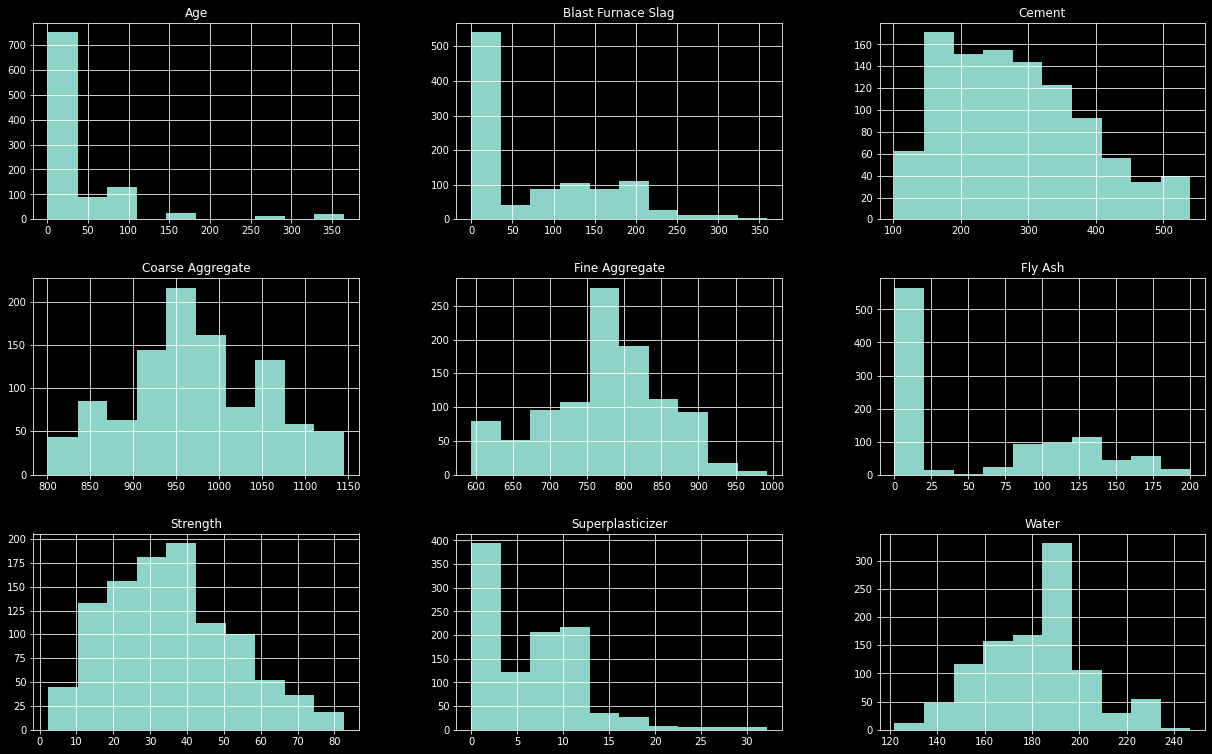

In [7]:
# Finally, let's also plot some histograms to have a better understanding 
# of the distribution of our feature columns: 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
concrete_data.hist(figsize=(21,13))
plt.show()

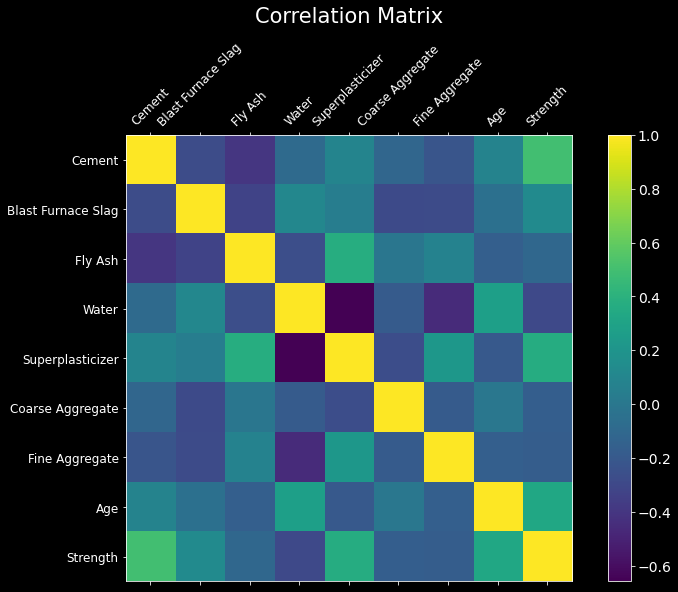

In [8]:
# Let's also plot a correlation matrix:
f = plt.figure(figsize=(13, 8))
plt.matshow(concrete_data.corr(), fignum=f.number)
plt.xticks(range(concrete_data.shape[1]), concrete_data.columns, fontsize=12, rotation=45)
plt.yticks(range(concrete_data.shape[1]), concrete_data.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=21, pad=90)
plt.show()

In [9]:
# Plot correlation values: 
corr = concrete_data.corr()
corr.loc[:,['Strength']].sort_values('Strength').style.background_gradient(cmap='viridis')

,Strength
Water,-0.289633
Fine Aggregate,-0.167241
Coarse Aggregate,-0.164935
Fly Ash,-0.105755
Blast Furnace Slag,0.134829
Age,0.328873
Superplasticizer,0.366079
Cement,0.497832
Strength,1.000000


We are interested in the correlation between strenght and the rest of the variables. The closer the number is to 1 or -1 the stronger the correlation. The closer the number is to 0, it immplies no correlation between the variables.
In the plots, the greener or yellow the variable, the more correlated they are. 

Looks like cement has a very strong positive correlation. Then, Superplasticizer, Age and Water also have some interesting correlation. The other materials seem not to have a strong impact to the strenght of the concrete mixture. 

## Data Preprocessing:

The data looks very clean as we saw in the data exploration phase because we don't need to take care of any missing values or cast different data types in this case. However, the data is not yet ready to be used in a neural network. There is some work to do like **splitting the features and target variables, data normalization and doing a train/test split**; so let's get to work on that. 

### Split Data into Predictors and Target datasets:

The target variable in this problem is the concrete sample strength, meaning this is the value we are trying to predict. Therefore, our predictors or independent variables will be all the other columns. This is what we mean by splitting our dataset into independent variables and target variable. 

In [10]:
# Split data into independent variables and target variable:
concrete_data_columns = concrete_data.columns

# All columns except for Strength, which is what we are trying to predict:
predictors = concrete_data[concrete_data_columns[concrete_data_columns != 'Strength']] 

# Target variable: 
target = concrete_data[['Strength']]

In [11]:
# Let's do a quick sanity check to make sure everything is alright:
predictors.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [12]:
# Let's do the same for the target variable: 
target.head()

,Strength
0,79.99
1,61.89
2,40.27
3,41.05
4,44.30


### Data Normalization:

If you look at the feature columns, you will notice that all of them are numbers but some of them have different magnitudes. This means that some of them are larger numbers when compared to the other feature columns. For example, on the histograms we plotted earlier, you'll see that 'Fine Aggregate' values are centered around the hundreds values but 'Age' values are centered between 0-100. We need to fix this, so that when we pass the data to the ML Algorithm, it doesn't create a bias towards certain features. In other words, if we don't normalize the data, the algorithm might give more importance to some features than others, thus creating a bias. You can find more information about normalization or feature scaling as it is also referred [here](https://en.wikipedia.org/wiki/Feature_scaling).

In [13]:
# Import StandardScaler for Normalization:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_norm = scaler.fit_transform(predictors)
y_norm = scaler.fit_transform(target)

In [14]:
# Let's save the number of predictors to a variable since
# we will need this number when building our network:
n_cols = X_norm.shape[1] 

### Train Test Split:

Finally, the reason we need to split the data into a training and testing sets is because we need to evaluate our model in data that is new to the model. Otherwise, if we use the entire dataset for training, it could just 'memorize' our data but when given new examples that has never seen before, it will most likely perform badly. That is why we will hold onto a 30% of out data for testing our model after training. This 30% will represent examples that the model has never seen before; therefore, giving us a more realistic picture of the truly pridictive capabilities of the model. 

In [15]:
# Let's create our train and test datasets from the normalized data: 

# First, import a module from the sklearn library:
from sklearn.model_selection import train_test_split

# Split the data. We will hold onto 30% for testing further on:
X_train, X_test, y_train, y_test\
= train_test_split(X_norm, y_norm, test_size=0.30, random_state=69)

## Building a Neural Network with Keras:

For this model, we are creating a basic neural network with one input layer, two hidden layers and one output layer. For the activation function, we are using the ReLu function and Mean Squared Error will be our evaluation metric. Also, for optimizing the weights and biases of our network, we will use the Adam Algorithm. This are some of the most common settings when working with neural networks in this type of problems. Of course, the settings can and should be changed depending on what you are trying to accomplish. 

In [16]:
# Let's go ahead and import the Keras library and other required packages:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [17]:
# Let's define a function that defines our regression model:

def regression_model():
  
    """ Create a model with one hidden layer and 
    10 neurons. Since this is a regression problem,
    we only need one output neuron. For the optimizer
    we will use the Adam function and the evaluation
    metric will be MSE (mean squared error)."""

    # Build the model:
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    # Compile the model:
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Let's call the function now to create our model:
model = regression_model()    

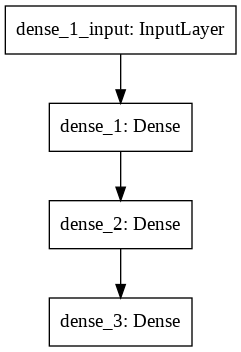

In [18]:
# For visualization purposes, let's plot the graph that represent our model:
import tensorflow as tf

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Training and Testing the Model:

Next, we will train our model on 100 epochs and then test the model. Epochs are the number of iterations over the entire training data. Once an epoch is completed, the network weights and biases are optimized and a new round will begin until all the iterations are completed. 

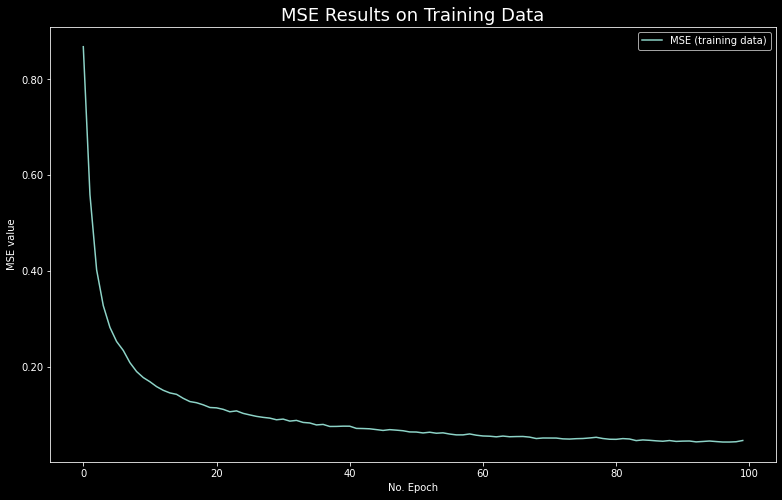


MSE Score on the Training Data after 100 epochs : 0.04553832806099139

MSE Mean over 100 epochs: 0.09917377502988149 
MSE Std Deviation over 100 epchs: 0.10954717445380062


In [19]:
# Train the model
Epochs = 100
training = model.fit(X_train, y_train, epochs=Epochs, verbose=0)

# Plot MSE Results:
from matplotlib.ticker import StrMethodFormatter
plt.figure(figsize=(13,8))
plt.plot(training.history['loss'], label='MSE (training data)')
plt.title('MSE Results on Training Data',fontsize=18)
plt.ylabel('MSE value')
plt.xlabel('No. Epoch')
plt.legend(loc="upper right")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.show()

print('\nMSE Score on the Training Data after {} epochs : {}'\
      .format(
          Epochs,training.history['loss'][-1]
          )
      )

print('\nMSE Mean over {} epochs: {} \nMSE Std Deviation over {} epchs: {}'\
      .format(
          Epochs,
          np.mean(training.history['loss']),
          Epochs,
          np.std(training.history['loss'])
      )
)

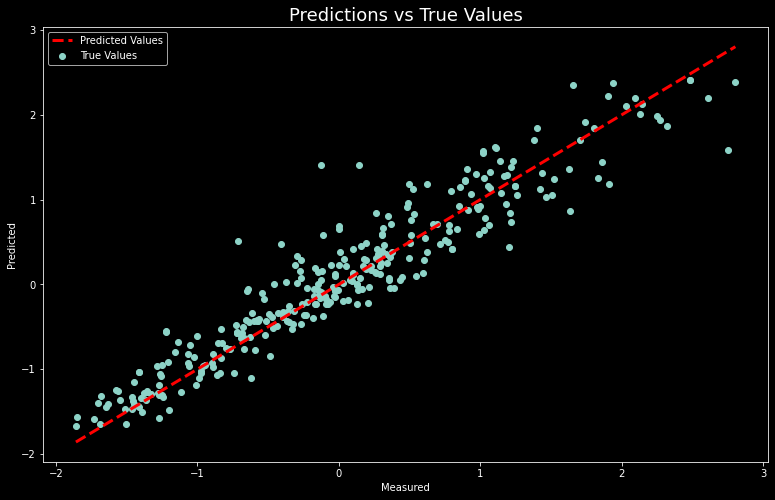


MSE Score on the Test Data: 0.10086117453310134


In [20]:
# import MSE to evaluate our predictions:
from sklearn.metrics import mean_squared_error

# Let's make some predictions: 
y_pred= model.predict(X_test)

# Plot predicted values versus true values:
plt.figure(figsize=(13,8))
plt.scatter(y_test, y_pred,
            label='True Values')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=3,
         label='Predicted Values')
plt.title('Predictions vs True Values', fontsize=18)
plt.ylabel('Predicted')
plt.xlabel('Measured')
plt.legend(loc="upper left")
plt.show()

print('\nMSE Score on the Test Data: {}'\
      .format(mean_squared_error(y_test, y_pred)))

## Conclusions:

On the last plot, once we make predictions using the test data that we had saved for evaluation, we see that these predictions represented by the red broken encompasses most of the true values pretty well except for some outliers. This means that our model is doing a good job at generalizing and it is not just memorizing our training data. Another observation is that we got a pretty low MSE in both the training and testing phase meaning that we are not overfitting the data. The lower the MSE the better as this means that our predictions are fairly close to the real values. 

Finally, as a conclusion I would like to mention that this is a rather simple model. Models used in production environments use huge amounts of data and the models consist of more complex architectures. That being said, this is a good exercise for experimentation purposes and would be a good starting point for someone looking into implementing machine learning for their business problems. Thanks everyone who took the time to read thorugh and I will greatly appreciate any feedback or comments. 

Cheers!

***